# Quantitative Value Strategy



_**This notebook is a continuation of EW_SP500 notebook, which you should find in the very same folder as this notebook.**_

"Value investing" means investing in the stocks that are cheapest relative to common measures of business value (like earnings or assets).

For this project, we're going to build an investing strategy that selects the 50 stocks with the best value metrics. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.


In [1]:
import numpy as np
import pandas as pd 
import requests 
import xlsxwriter 
import math 
from scipy import stats 

## Importing S&P 500 Stocks and API Calls

This part is essentially a copy-paste from the previous notebook, but in this case we are adding a new variable, which is the return of the stock in the last year (last 365 days). It must be said that the API provides with many other stats that can be used similarly, but in this case we will stick to this one because we are just trying to provide an example:

In [2]:
stocks = pd.read_csv('sp_500_stocks.csv')
from secrets import IEX_CLOUD_API_TOKEN

In [3]:
def groups(lst,n):
    for i in range(0,len(lst),n):
        yield lst[i:i+n] #yield returns a generator
        
symbol_groups = list(groups(stocks['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))

In [4]:
my_columns = ['Ticker', 'Price', 'Price-to-Earnings Ratio', 'Number of Shares to Buy']


final_dataframe = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        final_dataframe = final_dataframe.append(
                                        pd.Series([symbol, 
                                                   data[symbol]['quote']['latestPrice'],
                                                   data[symbol]['stats']['peRatio'], #stats is the endpoint, check documentation
                                                   'N/A'
                                                   ], 
                                                  index = my_columns), 
                                        ignore_index = True)
        
    
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Number of Shares to Buy
0,A,120.49,55.4448,N/A
1,AAL,17.16,-1.69128,N/A
2,AAP,162.50,23.3946,N/A
3,AAPL,124.23,37.7897,N/A
4,ABBV,110.35,26.1305,N/A
...,...,...,...,...
500,YUM,107.99,31.4727,N/A
501,ZBH,147.81,-200.776,N/A
502,ZBRA,386.83,42.8108,N/A
503,ZION,43.23,17.7149,N/A


## Removing Glamour Stock


Let's just stick to the 50 lowest-P/E stocks in the S&P 500.
In order to do this, we must remove those with negative P/E ratios (negative earnings) and sort the DataFrame:

In [5]:
final_dataframe = final_dataframe[final_dataframe["Price-to-Earnings Ratio"]>0].sort_values("Price-to-Earnings Ratio",ascending=True) #bear in mind that ascending is True now
final_dataframe = final_dataframe[:51] #we only want the first 50
final_dataframe.reset_index(drop=True,inplace=True) #index reset

In [6]:
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Number of Shares to Buy
0,NRG,34.82,2.00512,N/A
1,NLOK,19.72,3.7096,N/A
2,BIO,568.51,4.89177,N/A
3,UNM,23.39,5.11857,N/A
4,KIM,15.27,6.66733,N/A
5,EBAY,50.61,6.77231,N/A
6,ALL,107.63,7.13337,N/A
7,BIIB,242.47,7.40525,N/A
8,DISH,36.96,7.57435,N/A
9,MET,47.70,7.85473,N/A


## Calculating the Number of Shares to Buy

Let's just define a function with the code we had in the previous notebook:

In [7]:
def number_shares_to_dataframe(dataframe):

    portfolio_size = input("Enter the value of your portfolio")

    try:
        val = float(portfolio_size)
    except ValueError:
        print("Please, enter a numerical value")
        portfolio_size = input("Enter the value of  your portfolio")
        val=float(portfolio_size)


    position_size = val/len(dataframe.index) #since we want EW portfolio, the size of each position is the same

    dataframe["Number of Shares to Buy"] =position_size/ dataframe["Price"] #we assume the name of the columns is that one

In [8]:
number_shares_to_dataframe(final_dataframe)

Enter the value of your portfolio 1000


In [9]:
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Number of Shares to Buy
0,NRG,34.82,2.00512,0.563120
1,NLOK,19.72,3.7096,0.994313
2,BIO,568.51,4.89177,0.034490
3,UNM,23.39,5.11857,0.838300
4,KIM,15.27,6.66733,1.284076
5,EBAY,50.61,6.77231,0.387430
6,ALL,107.63,7.13337,0.182178
7,BIIB,242.47,7.40525,0.080867
8,DISH,36.96,7.57435,0.530515
9,MET,47.70,7.85473,0.411066


## Building More Complex Value Strategy
Every valuation metric has certain flaws.

In this section, we will filter for stocks with the **lowest percentiles** on the following metrics:

* Price-to-earnings ratio
* Price-to-book ratio
* Price-to-sales ratio
* Enterprise Value divided by Earnings Before Interest, Taxes, Depreciation, and Amortization (EV/EBITDA)
* Enterprise Value divided by Gross Profit (EV/GP)

Not all of these metrics are provided by the API, but we can obtain them by using some that are.

In [109]:
def pe_ratio(symbol):
    return data[symbol]['quote']['peRatio']


def pb_ratio(symbol):
    return data[symbol]['advanced-stats']['priceToBook']

def ps_ratio(symbol):
    return data[symbol]['advanced-stats']['priceToSales']

def ev_ebitda(symbol): #EV/EBITDA
    enterprise_value = data[symbol]['advanced-stats']['enterpriseValue']
    ebitda = data[symbol]['advanced-stats']['EBITDA']
    ev_to_ebitda = enterprise_value/ebitda
    return ev_to_ebitda

def ev_gp(symbol):
    enterprise_value = data[symbol]['advanced-stats']['enterpriseValue']
    gross_profit = data[symbol]['advanced-stats']['grossProfit']
    ev_to_gross_profit = enterprise_value/gross_profit
    return ev_to_gross_profit

In [110]:
rv_columns = [
    'Ticker',
    'Price',
    'Number of Shares to Buy', 
    'Price-to-Earnings Ratio',
    'PE Percentile',
    'Price-to-Book Ratio',
    'PB Percentile',
    'Price-to-Sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

rv_dataframe = pd.DataFrame(columns = rv_columns)

for symbol_string in symbol_strings:
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote,advanced-stats&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        
        try: #this is required because some ev or ebitdas might be missing
            ev_to_ebitda = ev_ebitda(symbol)
        except TypeError:
            ev_to_ebitda = np.NaN
        
        try:
            ev_to_gp = ev_gp(symbol)
        except TypeError:
            ev_to_gp = np.NaN
            
        rv_dataframe = rv_dataframe.append(
            pd.Series([
                symbol,
                data[symbol]['quote']['latestPrice'], #we didnt build a function before, and now we are copying code
                'N/A',
                pe_ratio(symbol),
                'N/A',
                pb_ratio(symbol),
                'N/A',
                ps_ratio(symbol),
                'N/A',
                 ev_to_ebitda,
                'N/A',
                 ev_to_gp,
                'N/A',
                'N/A'
        ],
        index = rv_columns),
            ignore_index = True
        )

In [111]:
rv_dataframe

,Ticker,Price,Number of Shares to Buy,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,A,119.12,N/A,55.25,N/A,7.39,N/A,7.16,N/A,34.586910,N/A,13.436736,N/A,N/A
1,AAL,17.85,N/A,-1.25,N/A,-1.89,N/A,0.439,N/A,-6.282954,N/A,1.418492,N/A,N/A
2,AAP,159.70,N/A,23.27,N/A,2.94,N/A,1.11,N/A,10.990280,N/A,2.450218,N/A,N/A
3,AAPL,125.89,N/A,39.08,N/A,32.66,N/A,7.89,N/A,27.667470,N/A,19.584458,N/A,N/A
4,ABBV,108.66,N/A,23.61,N/A,12.86,N/A,4.77,N/A,16.365418,N/A,9.725202,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,108.40,N/A,32.28,N/A,-4.12,N/A,5.85,N/A,24.064832,N/A,10.479331,N/A,N/A
501,ZBH,147.09,N/A,-194.95,N/A,2.58,N/A,4.34,N/A,25.497886,N/A,7.338458,N/A,N/A
502,ZBRA,394.56,N/A,43.43,N/A,10.78,N/A,4.73,N/A,30.031372,N/A,11.191332,N/A,N/A
503,ZION,43.02,N/A,18.08,N/A,0.9714,N/A,2.3,N/A,10.317233,N/A,2.671362,N/A,N/A


We should try to remove those tickers with missing data:

In [112]:
rv_dataframe = rv_dataframe.dropna()

In [113]:
rv_dataframe

,Ticker,Price,Number of Shares to Buy,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,A,119.12,N/A,55.25,N/A,7.39,N/A,7.16,N/A,34.586910,N/A,13.436736,N/A,N/A
1,AAL,17.85,N/A,-1.25,N/A,-1.89,N/A,0.439,N/A,-6.282954,N/A,1.418492,N/A,N/A
2,AAP,159.70,N/A,23.27,N/A,2.94,N/A,1.11,N/A,10.990280,N/A,2.450218,N/A,N/A
3,AAPL,125.89,N/A,39.08,N/A,32.66,N/A,7.89,N/A,27.667470,N/A,19.584458,N/A,N/A
4,ABBV,108.66,N/A,23.61,N/A,12.86,N/A,4.77,N/A,16.365418,N/A,9.725202,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,108.40,N/A,32.28,N/A,-4.12,N/A,5.85,N/A,24.064832,N/A,10.479331,N/A,N/A
501,ZBH,147.09,N/A,-194.95,N/A,2.58,N/A,4.34,N/A,25.497886,N/A,7.338458,N/A,N/A
502,ZBRA,394.56,N/A,43.43,N/A,10.78,N/A,4.73,N/A,30.031372,N/A,11.191332,N/A,N/A
503,ZION,43.02,N/A,18.08,N/A,0.9714,N/A,2.3,N/A,10.317233,N/A,2.671362,N/A,N/A


## Calculating Value Percentiles




In [114]:
metrics =[
            'Price-to-Earnings Ratio',
            'Price-to-Book Ratio',
            'Price-to-Sales Ratio',
            'EV/EBITDA',
            'EV/GP']

metrics_percentiles= [
             'PE Percentile',
             'PB Percentile',
             'PS Percentile',
             'EV/EBITDA Percentile',
             'EV/GP Percentile',]


for i in range(len(metrics)): #only columns of returns. This line would have to be adapted
         #if percentiles and returns are located differently
         percentiles = rv_dataframe[metrics[i]].rank(pct=True)
         rv_dataframe.loc[:,metrics_percentiles[i]] = percentiles.loc[:] #we add the value to the percentile columns. 
         # it is necessary to write that line with .loc. If you don't, an error with a link to understand why will appear

C:\Users\jackt\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [115]:
rv_dataframe




,Ticker,Price,Number of Shares to Buy,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,A,119.12,N/A,55.25,0.860370,7.39,0.751540,7.16,0.811088,34.586910,0.889117,13.436736,0.817248,N/A
1,AAL,17.85,N/A,-1.25,0.147844,-1.89,0.047228,0.439,0.032854,-6.282954,0.028747,1.418492,0.059548,N/A
2,AAP,159.70,N/A,23.27,0.453799,2.94,0.431211,1.11,0.183778,10.990280,0.277207,2.450218,0.131417,N/A
3,AAPL,125.89,N/A,39.08,0.741273,32.66,0.958932,7.89,0.841889,27.667470,0.831622,19.584458,0.934292,N/A
4,ABBV,108.66,N/A,23.61,0.468172,12.86,0.856263,4.77,0.679671,16.365418,0.521561,9.725202,0.650924,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,108.40,N/A,32.28,0.669405,-4.12,0.043121,5.85,0.745380,24.064832,0.782341,10.479331,0.683778,N/A
501,ZBH,147.09,N/A,-194.95,0.020534,2.58,0.380903,4.34,0.640657,25.497886,0.806982,7.338458,0.496920,N/A
502,ZBRA,394.56,N/A,43.43,0.798768,10.78,0.829569,4.73,0.670431,30.031372,0.866530,11.191332,0.718686,N/A
503,ZION,43.02,N/A,18.08,0.361396,0.9714,0.100616,2.3,0.405544,10.317233,0.246407,2.671362,0.141684,N/A


Again, we check by plotting one of them:

<AxesSubplot:xlabel='PE Percentile', ylabel='Price-to-Earnings Ratio'>

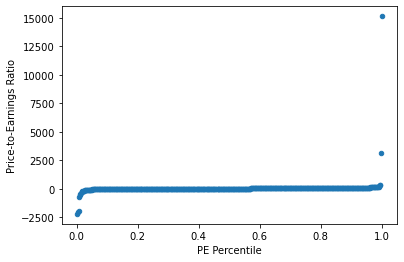

In [116]:
import matplotlib.pyplot as plt

rv_dataframe.plot.scatter(x=metrics_percentiles[0], y=metrics[0])

## Calculating RV Score:


We'll now calculate our RV Score, which, in this case, is the arithmetic mean of the 4 percentile scores that we calculated in the last section (in the same fashion as in the Momentum Strategy notebook):

In [117]:
rv_dataframe.loc[:,"RV Score"] = rv_dataframe[metrics_percentiles].mean(axis=1)

C:\Users\jackt\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [118]:
rv_dataframe

,Ticker,Price,Number of Shares to Buy,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,A,119.12,N/A,55.25,0.860370,7.39,0.751540,7.16,0.811088,34.586910,0.889117,13.436736,0.817248,0.825873
1,AAL,17.85,N/A,-1.25,0.147844,-1.89,0.047228,0.439,0.032854,-6.282954,0.028747,1.418492,0.059548,0.063244
2,AAP,159.70,N/A,23.27,0.453799,2.94,0.431211,1.11,0.183778,10.990280,0.277207,2.450218,0.131417,0.295483
3,AAPL,125.89,N/A,39.08,0.741273,32.66,0.958932,7.89,0.841889,27.667470,0.831622,19.584458,0.934292,0.861602
4,ABBV,108.66,N/A,23.61,0.468172,12.86,0.856263,4.77,0.679671,16.365418,0.521561,9.725202,0.650924,0.635318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,108.40,N/A,32.28,0.669405,-4.12,0.043121,5.85,0.745380,24.064832,0.782341,10.479331,0.683778,0.584805
501,ZBH,147.09,N/A,-194.95,0.020534,2.58,0.380903,4.34,0.640657,25.497886,0.806982,7.338458,0.496920,0.469199
502,ZBRA,394.56,N/A,43.43,0.798768,10.78,0.829569,4.73,0.670431,30.031372,0.866530,11.191332,0.718686,0.776797
503,ZION,43.02,N/A,18.08,0.361396,0.9714,0.100616,2.3,0.405544,10.317233,0.246407,2.671362,0.141684,0.251129


## Selecting Best Value Stocks

Again, we choose the 50 stocks with the best RV, that is, the stocks with lowest RV. Before, we must remove those stock with negative P/E and P/B ratios, something that is not done in the course:

In [134]:
best_rv_dataframe = rv_dataframe[(rv_dataframe["Price-to-Earnings Ratio"]>0) & (rv_dataframe["Price-to-Book Ratio"]>0)] #syntax is important
best_rv_dataframe = best_rv_dataframe.sort_values("RV Score",ascending=True) #rember to change ascending to True
best_rv_dataframe = best_rv_dataframe[:51] #we only want the first 50
best_rv_dataframe.reset_index(drop=True,inplace=True) #index reset

In [136]:
best_rv_dataframe

,Ticker,Price,Number of Shares to Buy,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,UNM,24.17,N/A,5.08,0.160164,0.4512,0.049281,0.4097,0.030801,2.517509,0.034908,0.391138,0.004107,0.055852
1,MET,49.05,N/A,8.02,0.168378,0.5915,0.061602,0.6644,0.061602,4.256466,0.041068,0.627593,0.012320,0.068994
2,HIG,47.30,N/A,9.68,0.182752,0.9552,0.098563,0.8024,0.082136,4.131466,0.039014,0.818847,0.022587,0.085010
3,ALL,105.44,N/A,7.4,0.164271,1.32,0.176591,0.7421,0.073922,2.297026,0.032854,0.700224,0.014374,0.092402
4,PFG,49.86,N/A,11.46,0.209446,0.8972,0.090349,0.9322,0.117043,7.522770,0.104723,0.901151,0.028747,0.110062
5,LNC,53.53,N/A,13.1,0.238193,0.4627,0.051335,0.5891,0.053388,9.597021,0.207392,0.561001,0.010267,0.112115
6,VIAC,35.80,N/A,11.28,0.205339,1.57,0.225873,0.6276,0.057495,5.960925,0.057495,1.107518,0.036961,0.116632
7,CVS,72.27,N/A,12.05,0.221766,1.38,0.189938,0.3582,0.022587,7.928932,0.129363,1.470119,0.063655,0.125462
8,C,59.27,N/A,11.69,0.212526,0.7149,0.065708,1.34,0.221766,6.550847,0.075975,1.580799,0.071869,0.129569
9,KR,32.23,N/A,9.95,0.188912,2.54,0.377823,0.1891,0.008214,5.985485,0.059548,1.176170,0.043121,0.135524


## Calculating the Number of Shares to Buy

In [137]:
number_shares_to_dataframe(best_rv_dataframe)

Enter the value of your portfolio 1000


In [139]:
best_rv_dataframe.head()

,Ticker,Price,Number of Shares to Buy,Price-to-Earnings Ratio,PE Percentile,Price-to-Book Ratio,PB Percentile,Price-to-Sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score
0,UNM,24.17,0.811247,5.08,0.160164,0.4512,0.049281,0.4097,0.030801,2.517509,0.034908,0.391138,0.004107,0.055852
1,MET,49.05,0.399752,8.02,0.168378,0.5915,0.061602,0.6644,0.061602,4.256466,0.041068,0.627593,0.012320,0.068994
2,HIG,47.30,0.414542,9.68,0.182752,0.9552,0.098563,0.8024,0.082136,4.131466,0.039014,0.818847,0.022587,0.085010
3,ALL,105.44,0.185962,7.4,0.164271,1.32,0.176591,0.7421,0.073922,2.297026,0.032854,0.700224,0.014374,0.092402
4,PFG,49.86,0.393258,11.46,0.209446,0.8972,0.090349,0.9322,0.117043,7.522770,0.104723,0.901151,0.028747,0.110062


## Obtaining the .xlxs file

In [142]:
writer = pd.ExcelWriter('recommended_trades_value.xlsx', engine='xlsxwriter')
best_rv_dataframe.to_excel(writer, sheet_name='Value Strategy', index = False)

In [143]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_format = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_format = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_format = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

float_format = writer.book.add_format(   #new addition
        {
            'num_format':'0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [144]:
column_formats = {
                    'A': ['Ticker', string_format],
                    'B': ['Price', dollar_format],
                    'C': ['Number of Shares to Buy', float_format],
                    'D': ['Price-to-Earnings Ratio', float_format],
                    'E': ['PE Percentile', float_format],
                    'F': ['Price-to-Book Ratio', float_format],
                    'G': ['PB Percentile',float_format],
                    'H': ['Price-to-Sales Ratio', float_format],
                    'I': ['PS Percentile', float_format],
                    'J': ['EV/EBITDA', float_format],
                    'K': ['EV/EBITDA Percentile', float_format],
                    'L': ['EV/GP', float_format],
                    'M': ['EV/GP Percentile', float_format],
                    'N': ['RV Score', float_format]
                 }

for column in column_formats.keys():
    writer.sheets['Value Strategy'].set_column(f'{column}:{column}', 25, column_formats[column][1])
    writer.sheets['Value Strategy'].write(f'{column}1', column_formats[column][0], column_formats[column][1])

In [145]:
writer.save()

## References

Algorithmic Trading Using Python - Full Course : https://www.youtube.com/watch?v=xfzGZB4HhEE&t=14236s